In [1]:
import uproot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
import timeit
import copy
import torch

plt.style.use('niceplots')

In [2]:
# read input hdf5

# inputfile = '/nfs/dust/belle2/user/ferber/eclml-monitoring/inference-2021-03-10-test/inference.hdf5'
# inputfile = '/nfs/dust/belle2/user/ferber/github-ECLML/test/inference-image.hdf5'
inputfile = '/nfs/dust/belle2/user/ferber/eclml-monitoring/20210321-074315-40870/inference-image.hdf5'
starttime = timeit.default_timer()

h5f = h5py.File(inputfile,'r')
input_phi = h5f['input_phi'][:]
input_theta = h5f['input_theta'][:]
input_energy = h5f['input_energy'][:]
target_t0 = h5f['target_t0'][:]
target_t1 = h5f['target_t1'][:]
target_tbkg = h5f['target_tbkg'][:]
target_p0 = h5f['target_p0'][:]
target_p1 = h5f['target_p1'][:]
target_pbkg = h5f['target_pbkg'][:]

clstw0 = h5f['clstw0'][:]
clstw1 = h5f['clstw1'][:]
clstid0 = h5f['clstid0'][:]
clstid1 = h5f['clstid1'][:]
psd = h5f['psd'][:]
time = h5f['time'][:]
mass = h5f['mass'][:]
failedfit = h5f['failedfit'][:]
fittype = h5f['fittype'][:]

mon_E0 = h5f['mon_E0'][:]
mon_E1 = h5f['mon_E1'][:]
mon_theta0 = h5f['mon_theta0'][:]
mon_theta1 = h5f['mon_theta1'][:]
mon_phi0 = h5f['mon_phi0'][:]
mon_phi1 = h5f['mon_phi1'][:]
mon_angle = h5f['mon_angle'][:]
mon_nshared = h5f['mon_nshared'][:]
mon_n0 = h5f['mon_n0'][:]
mon_n1 = h5f['mon_n1'][:]
mon_e0_sel = h5f['mon_e0_sel'][:]
mon_e1_sel = h5f['mon_e1_sel'][:]
mon_e0_tot = h5f['mon_e0_tot'][:]
mon_e1_tot = h5f['mon_e1_tot'][:]
mon_e0_overlap = h5f['mon_e0_overlap'][:]
mon_e1_overlap = h5f['mon_e1_overlap'][:]

h5f.close()
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.15650052297860384


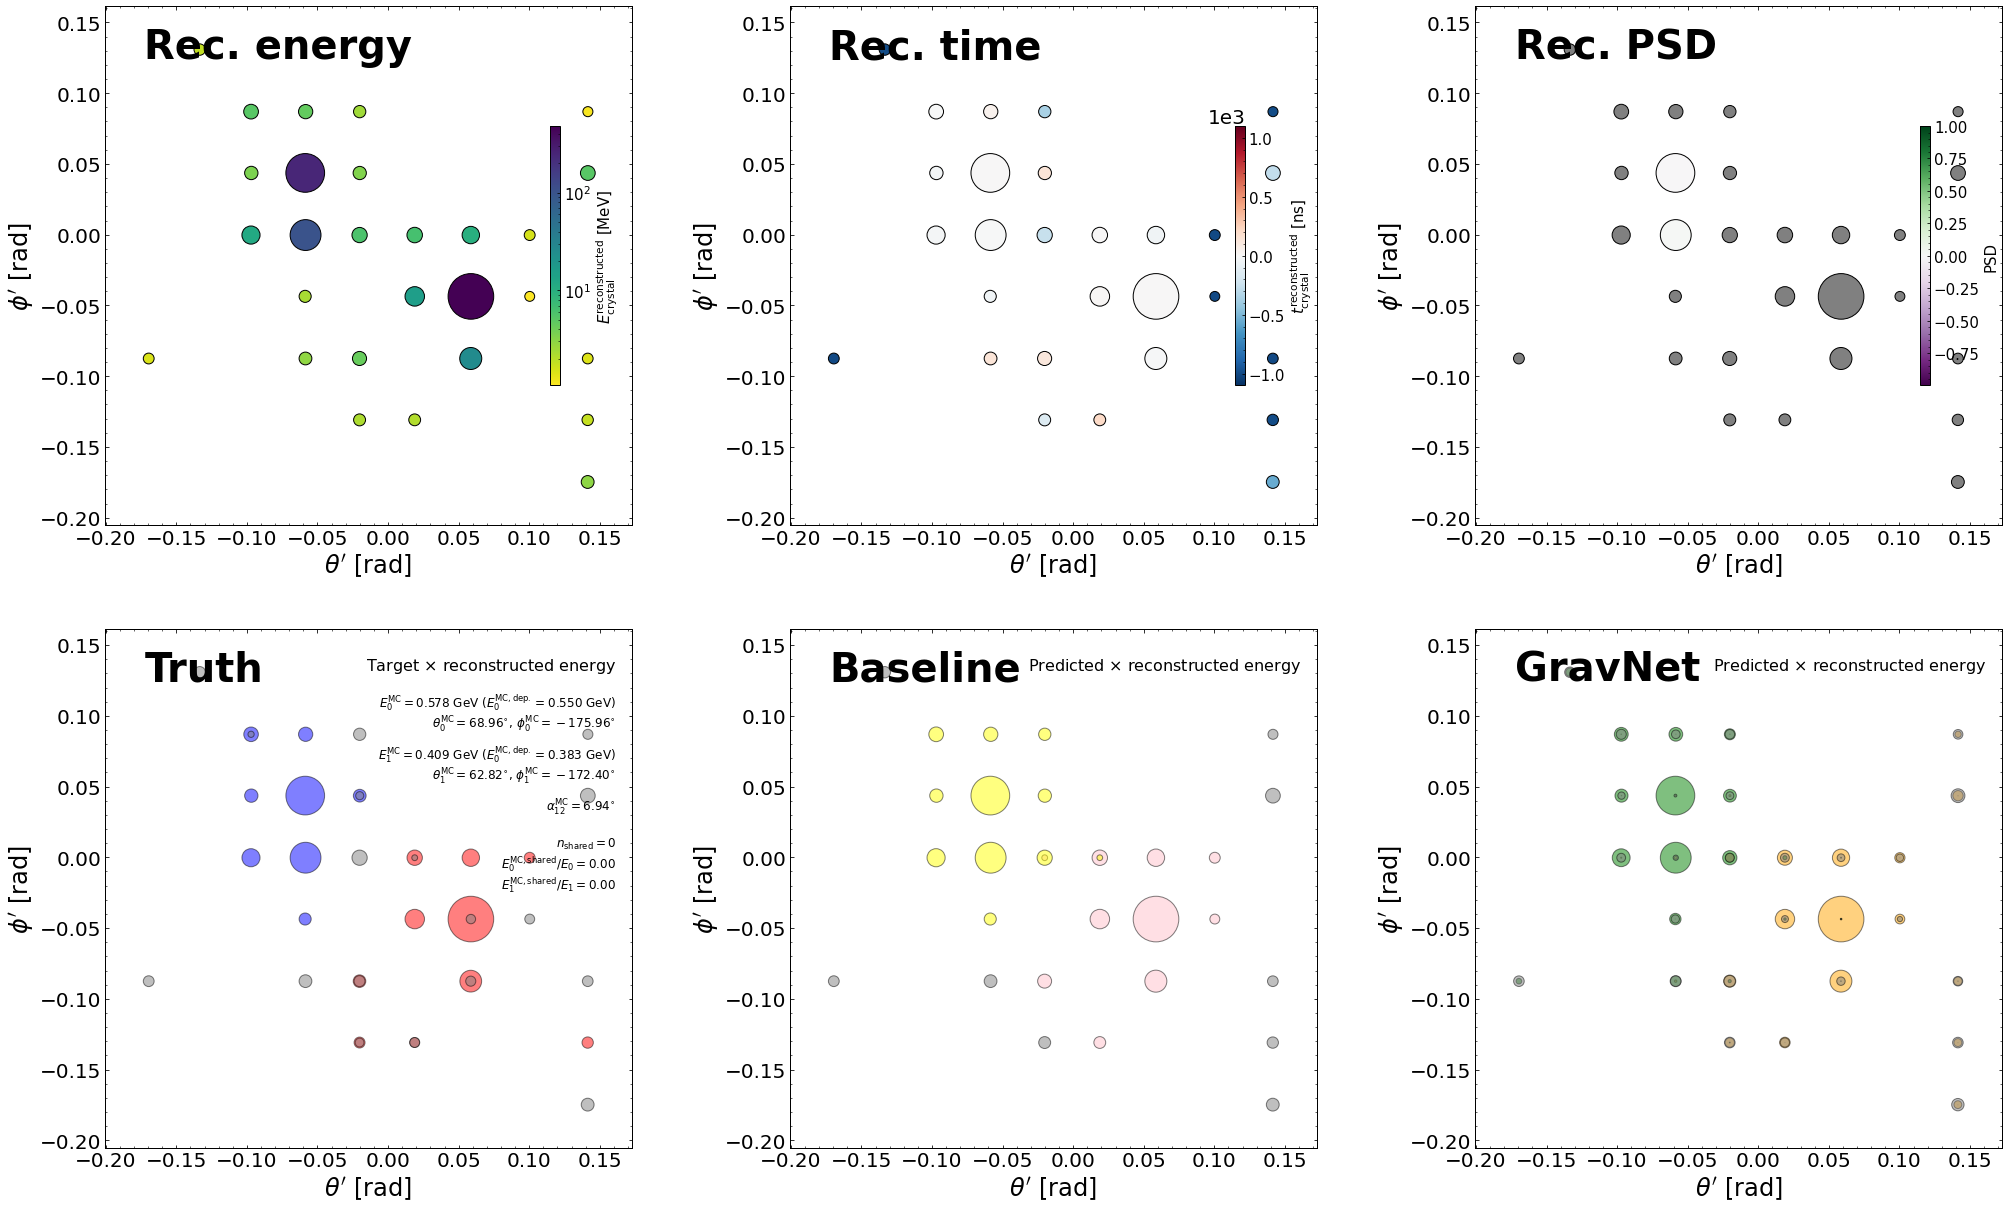

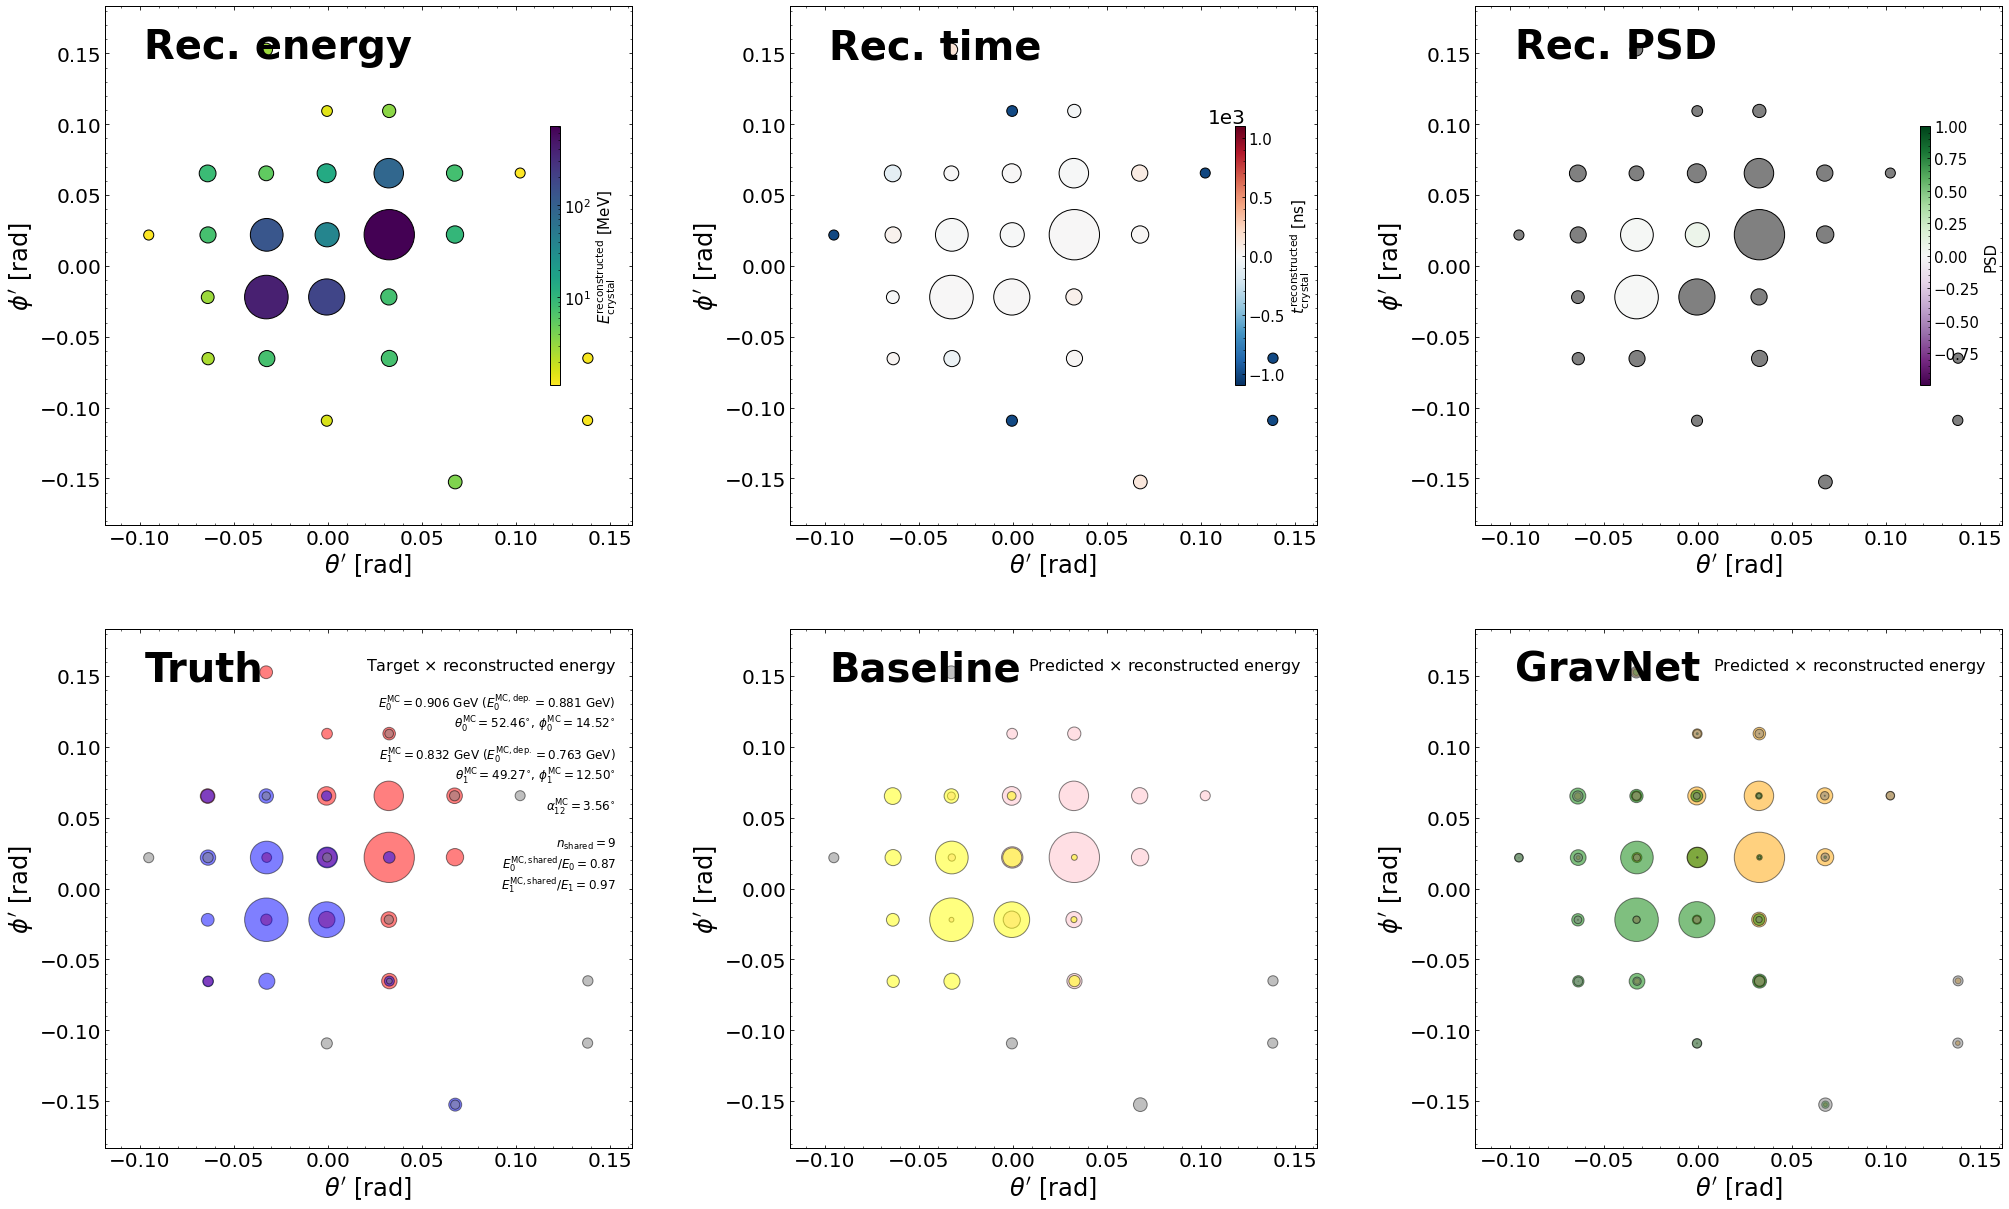

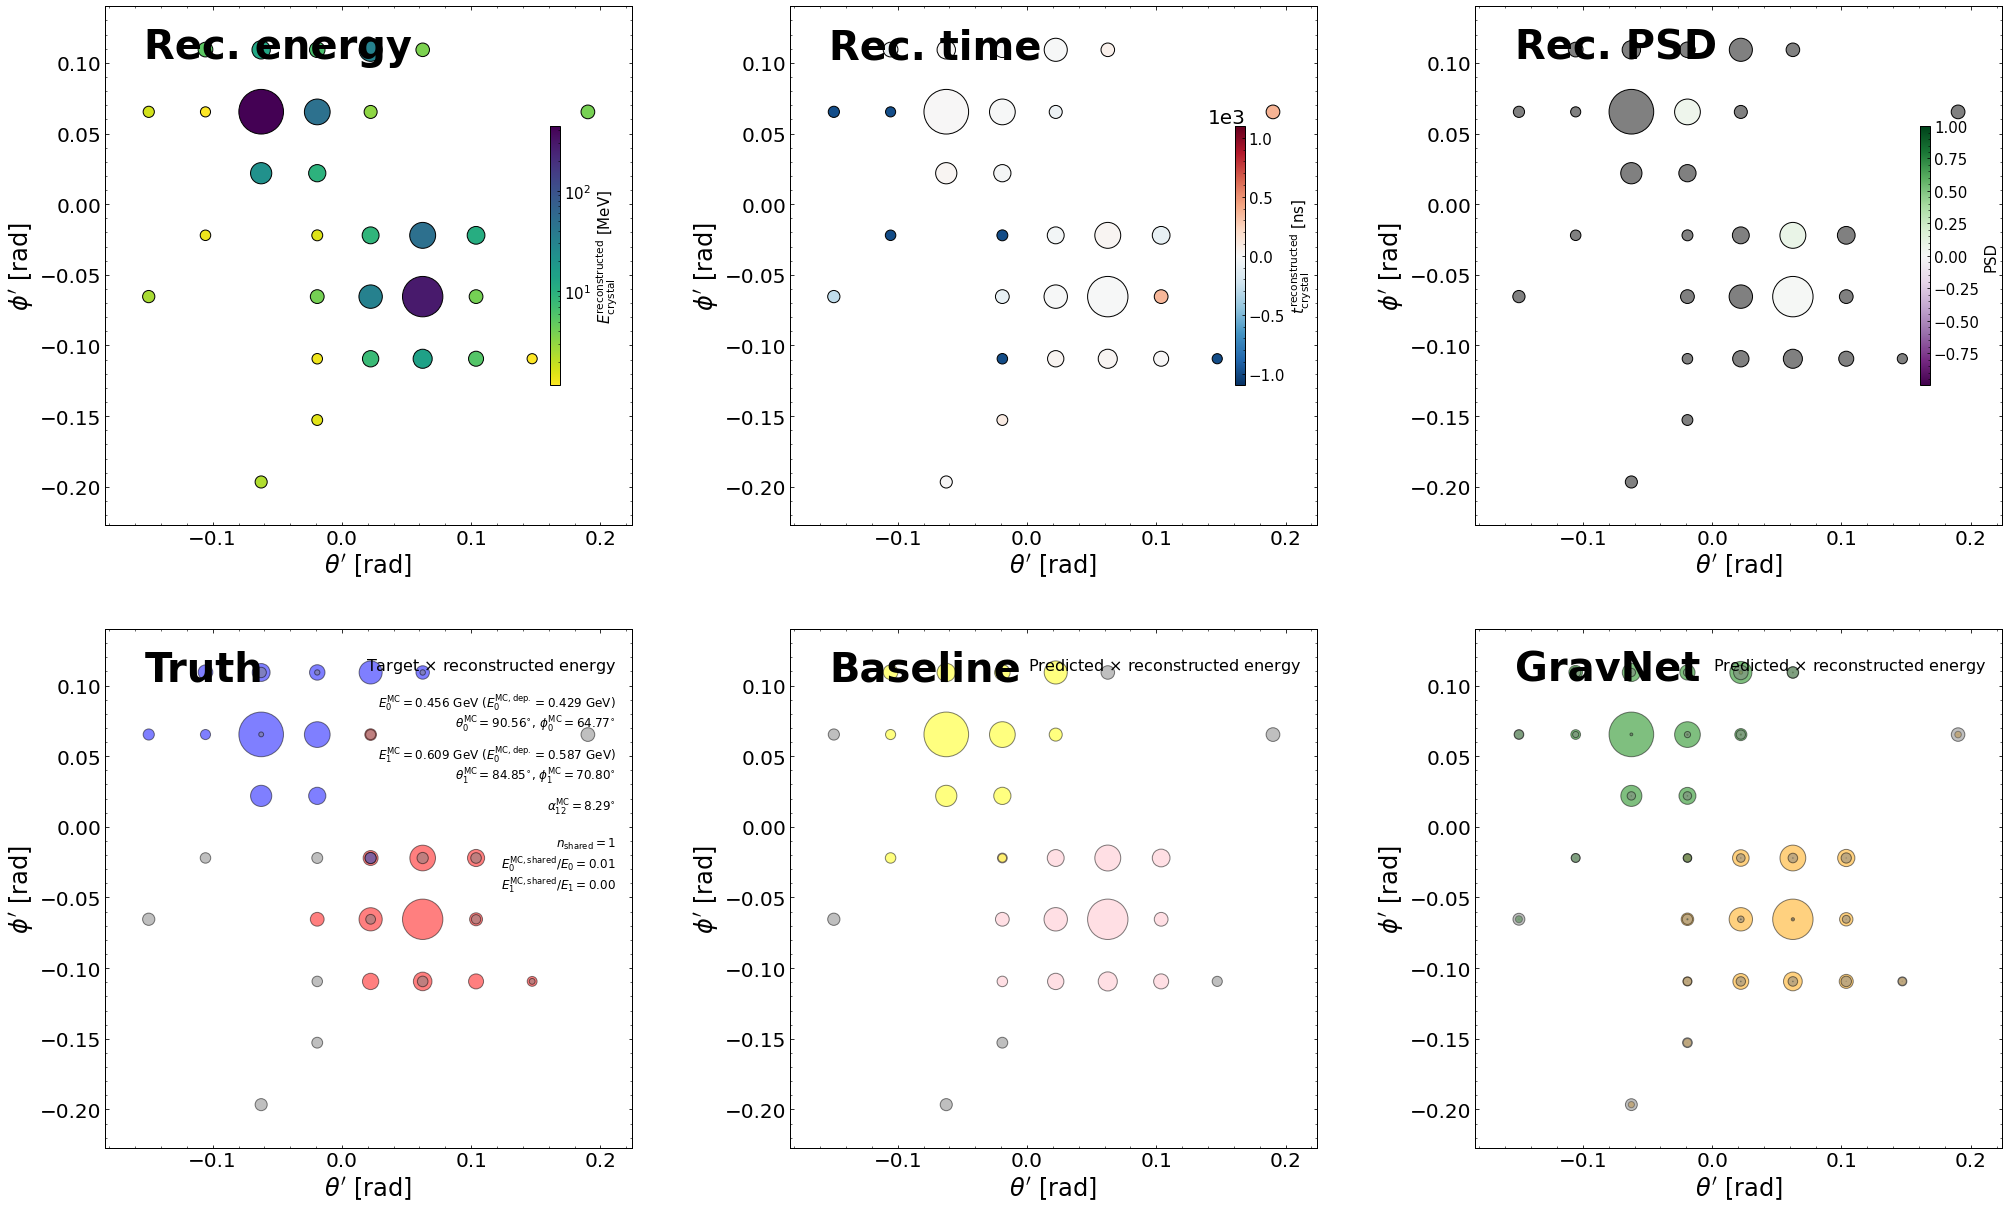

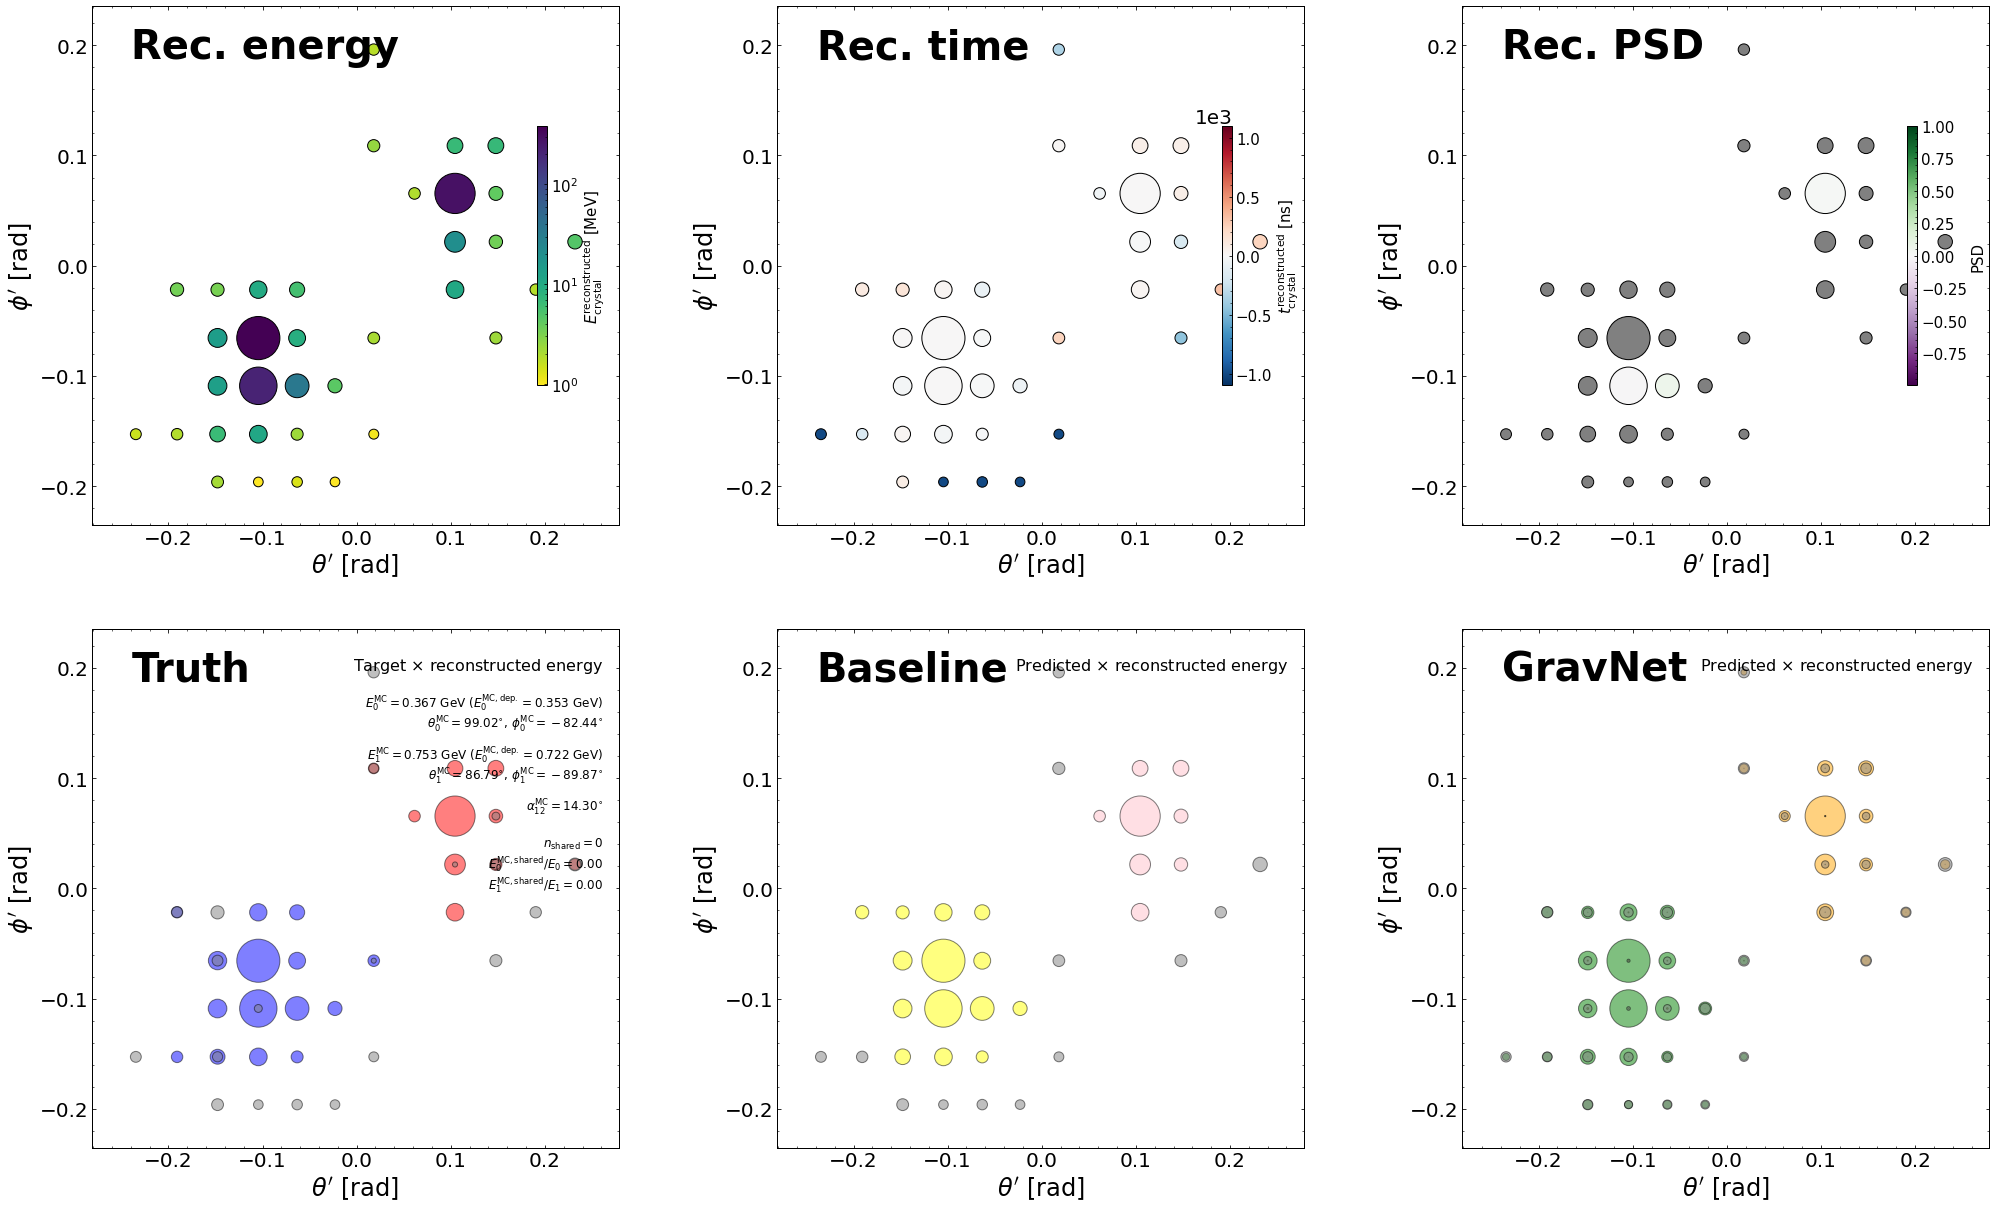

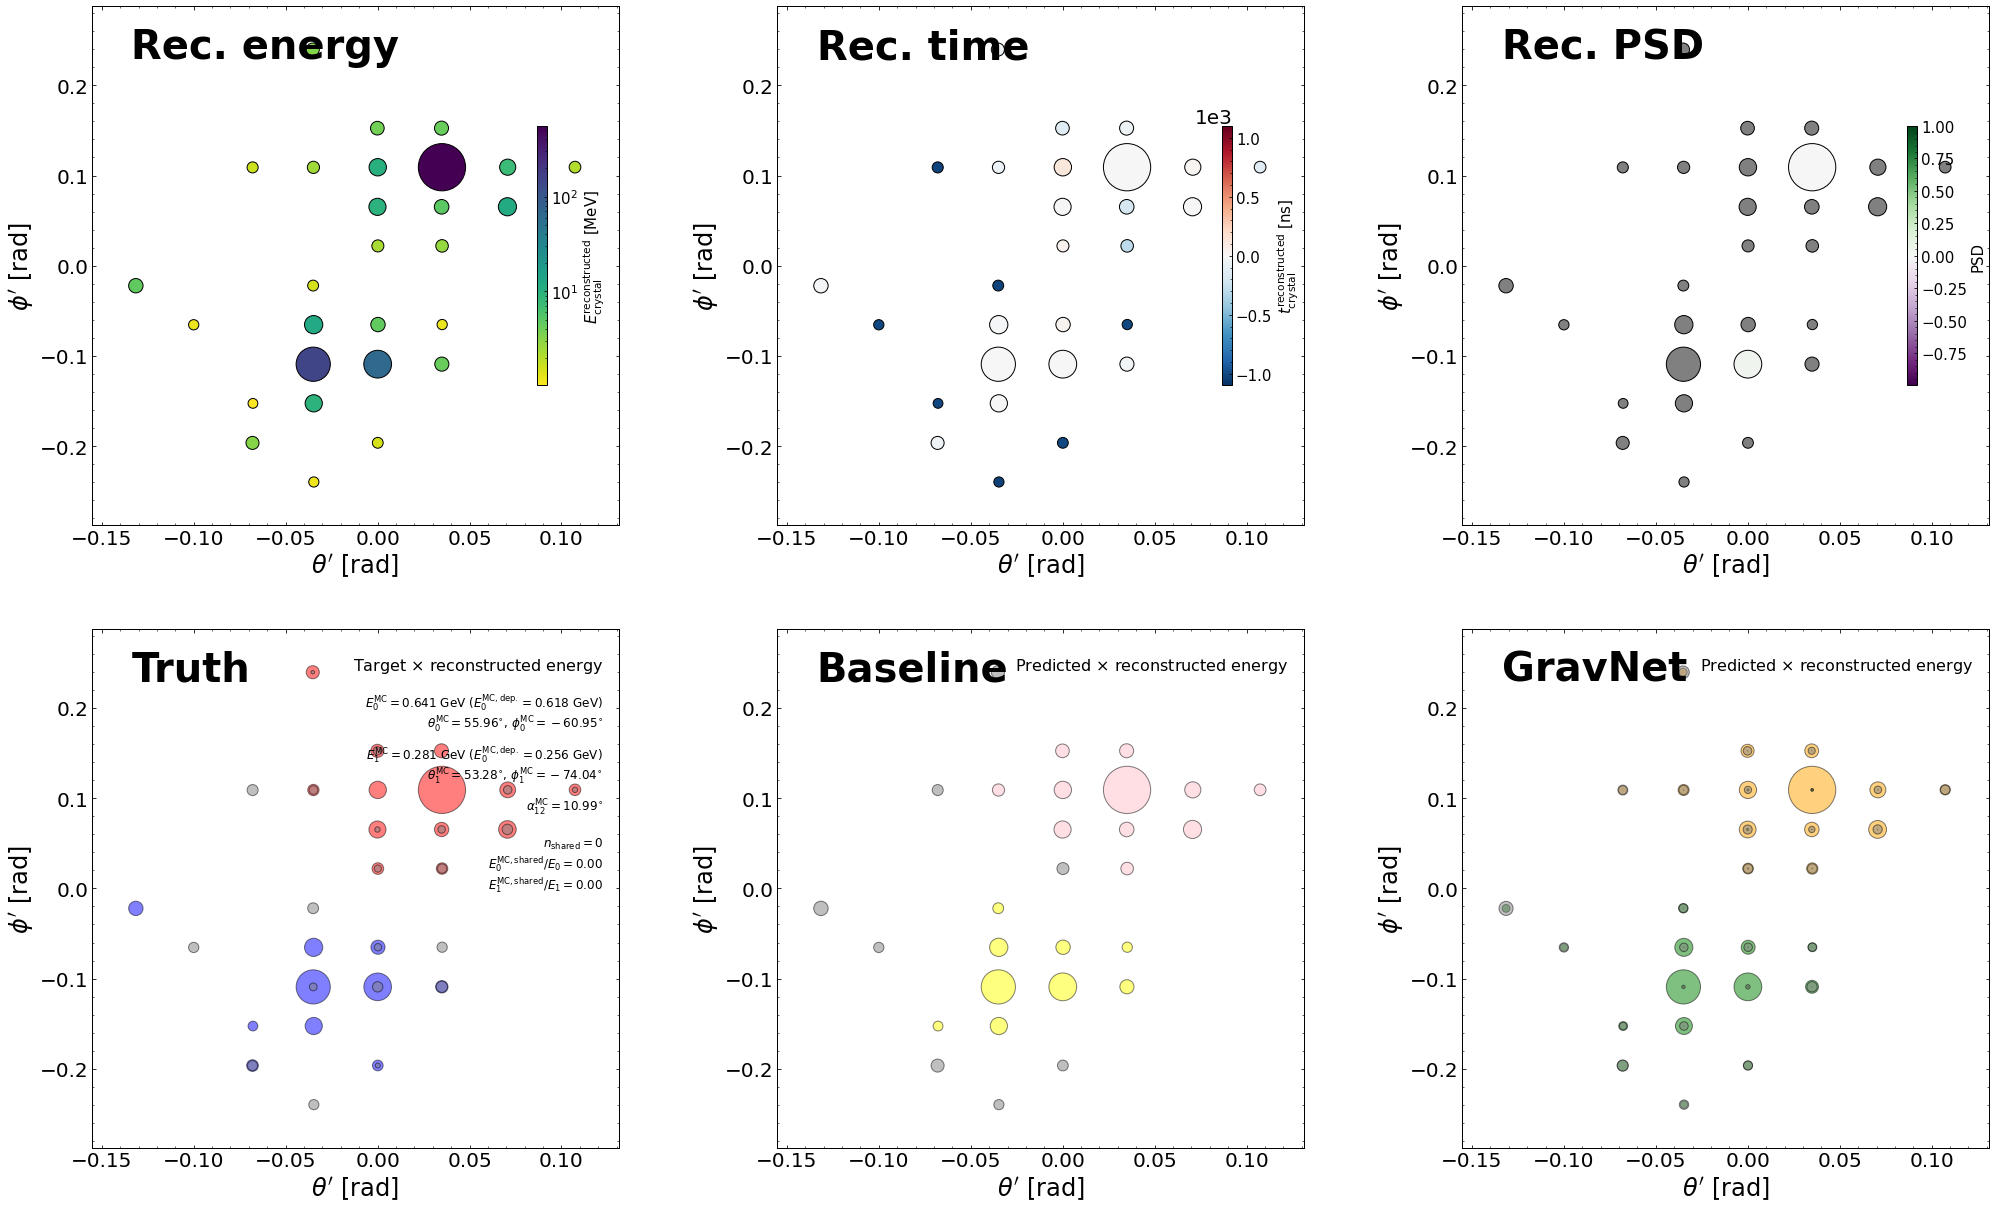

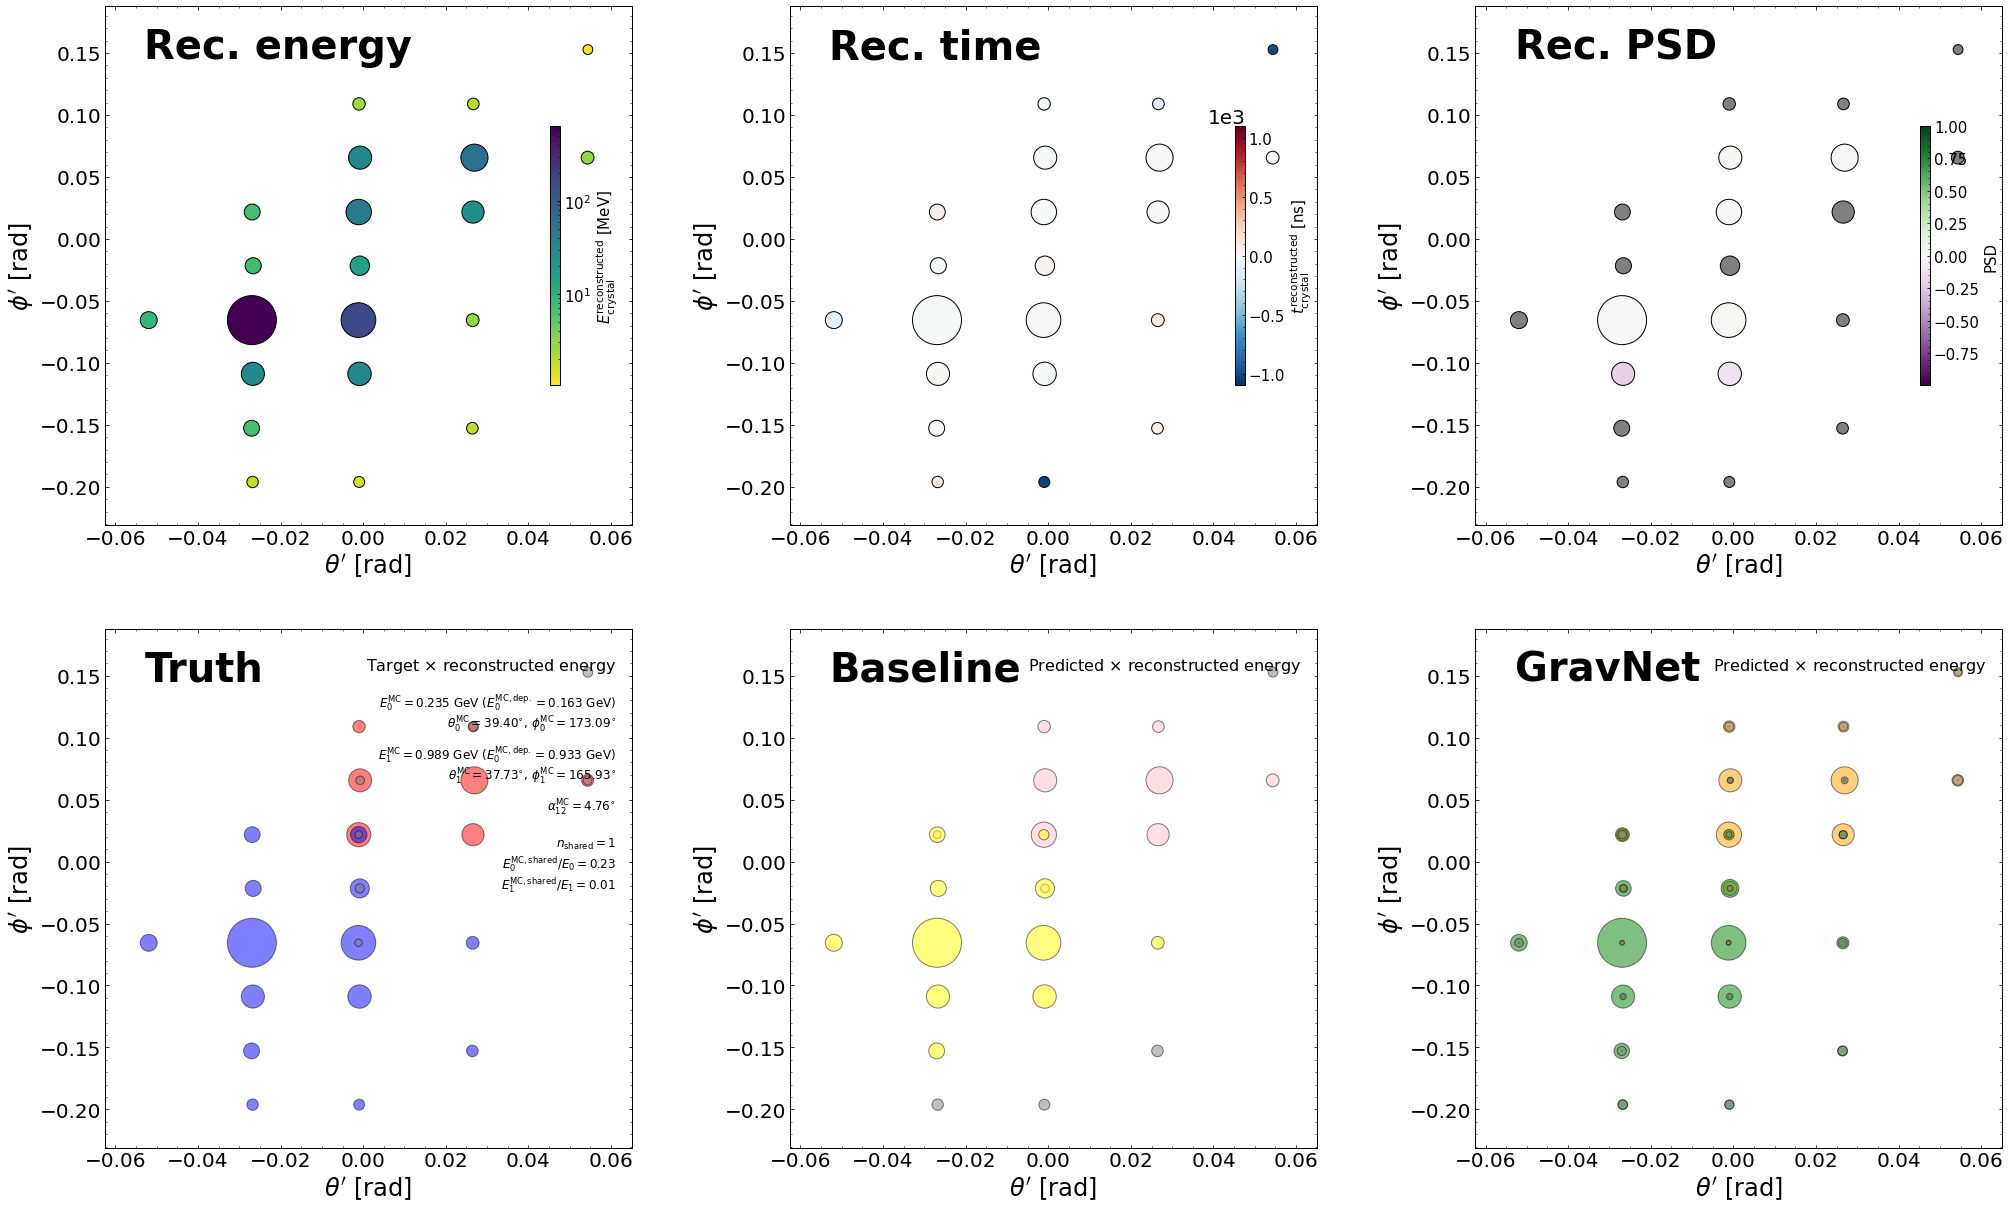

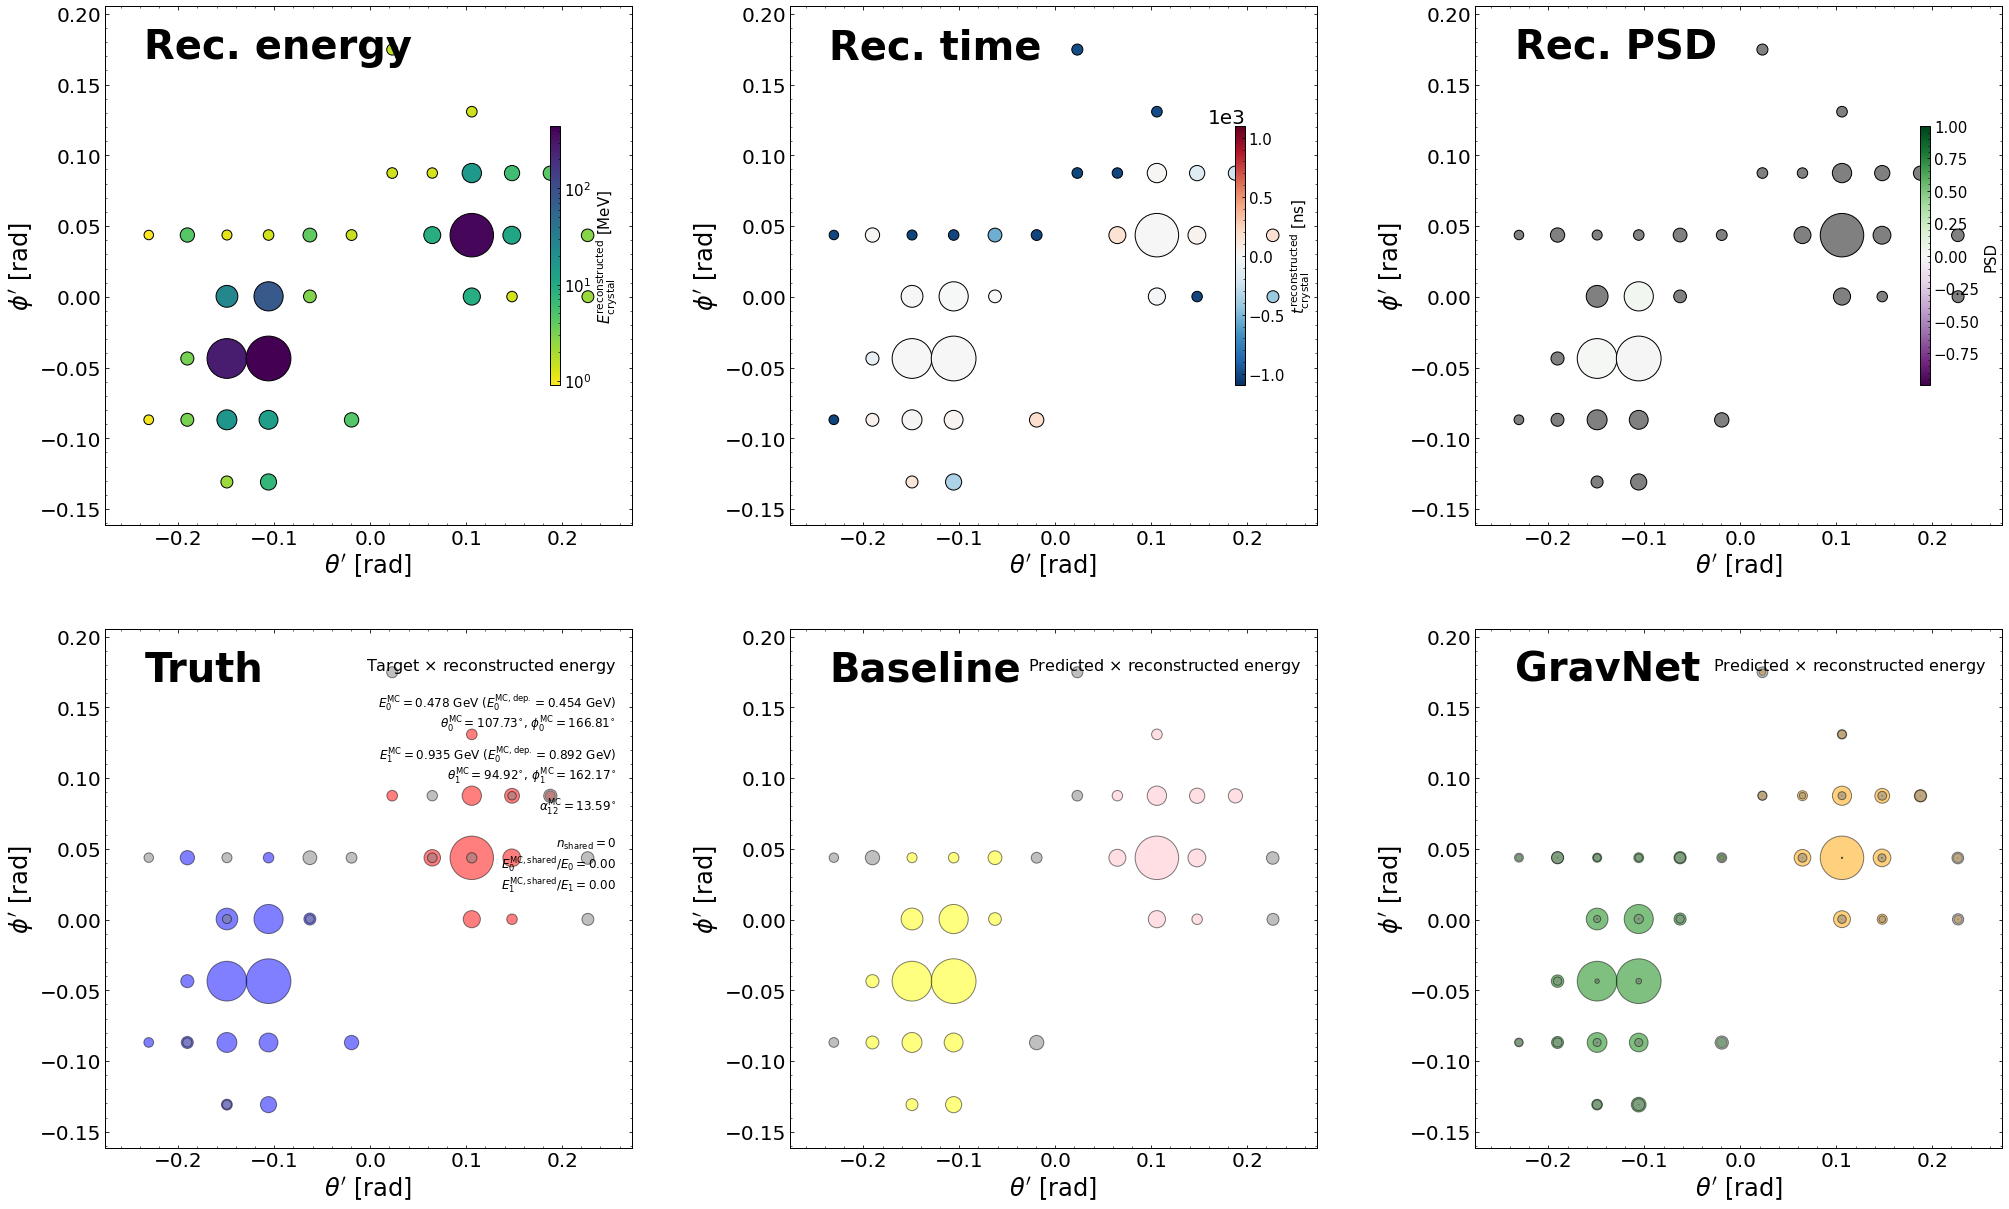

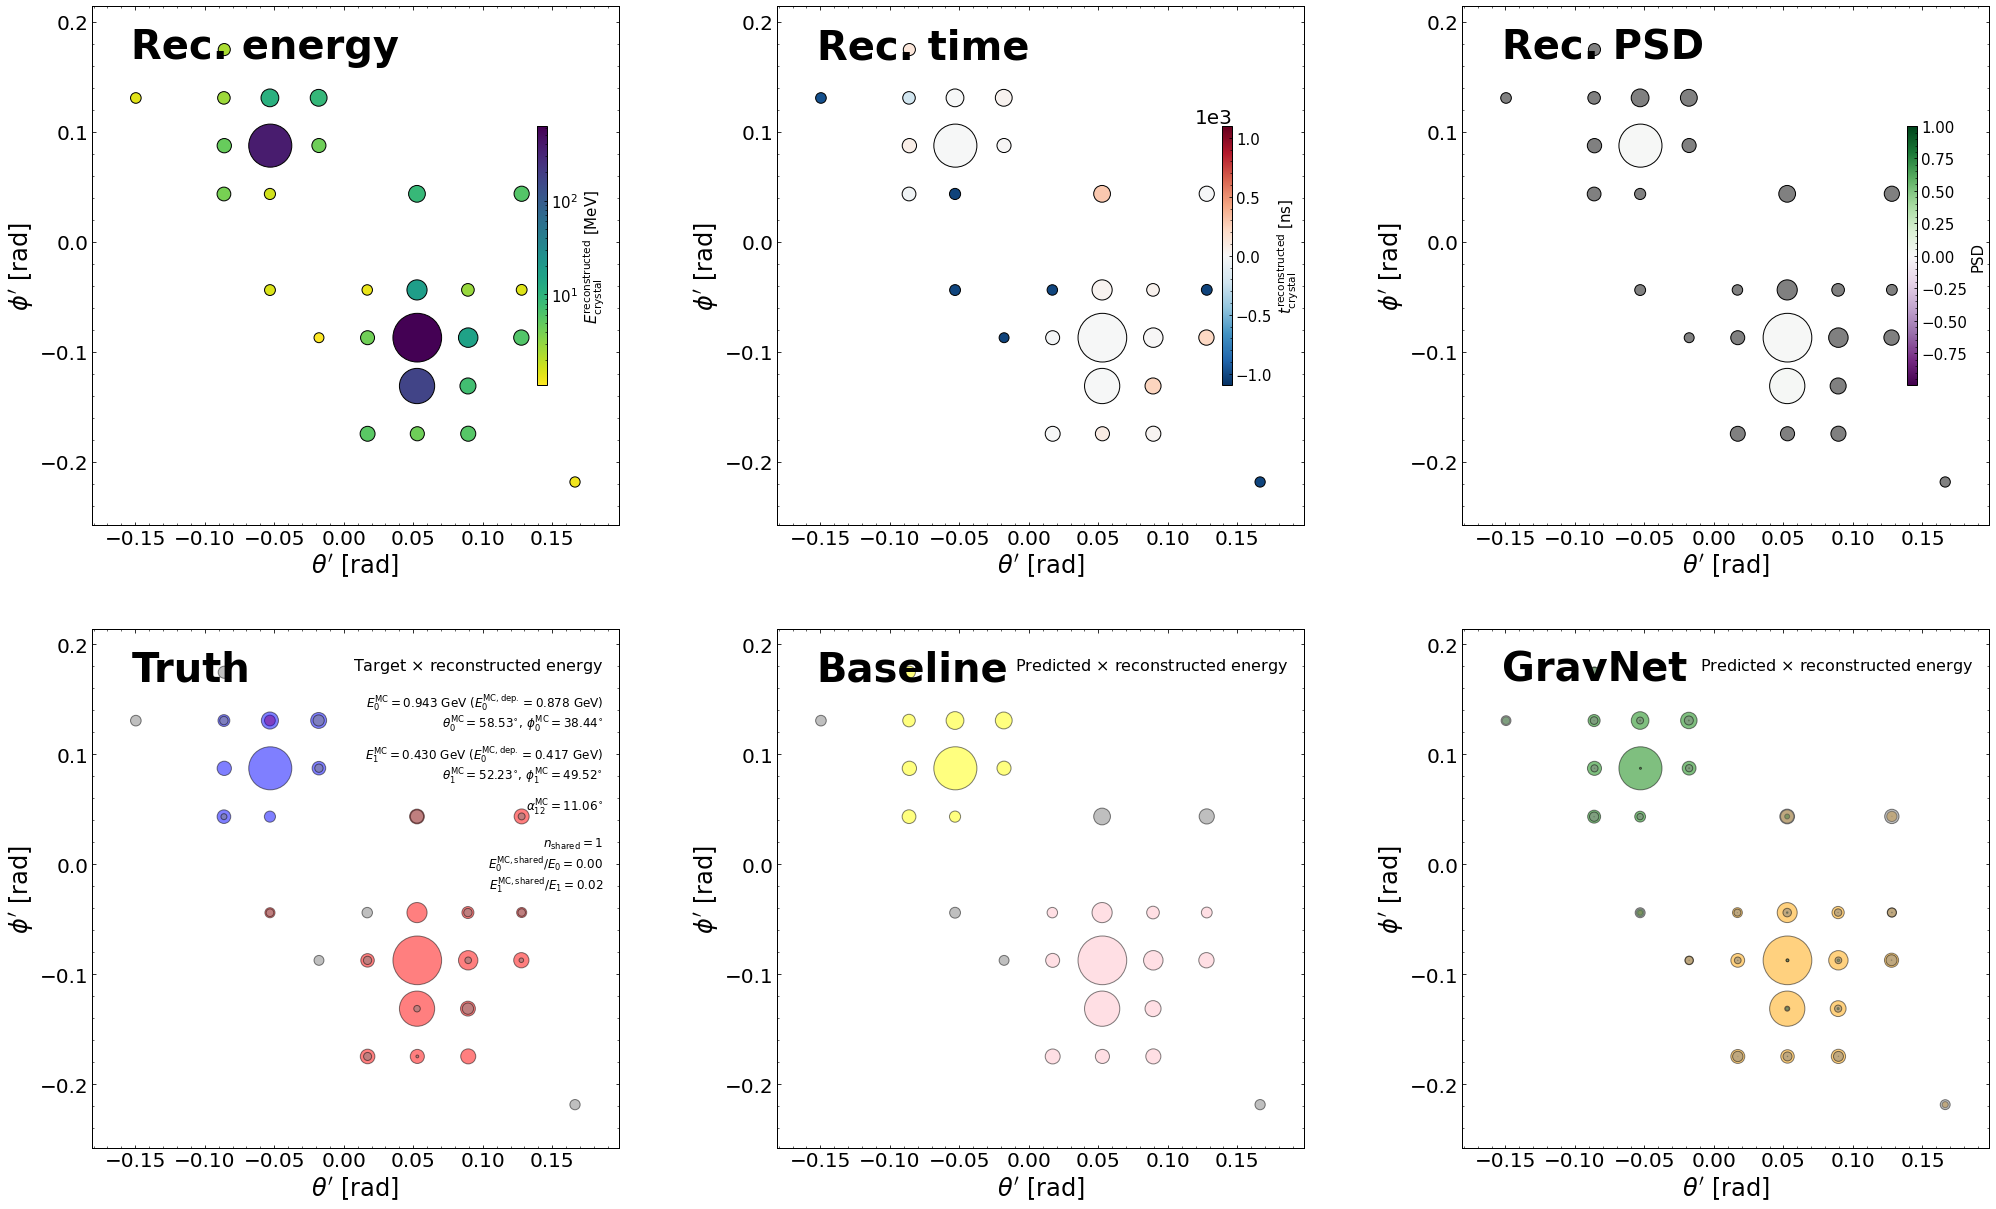

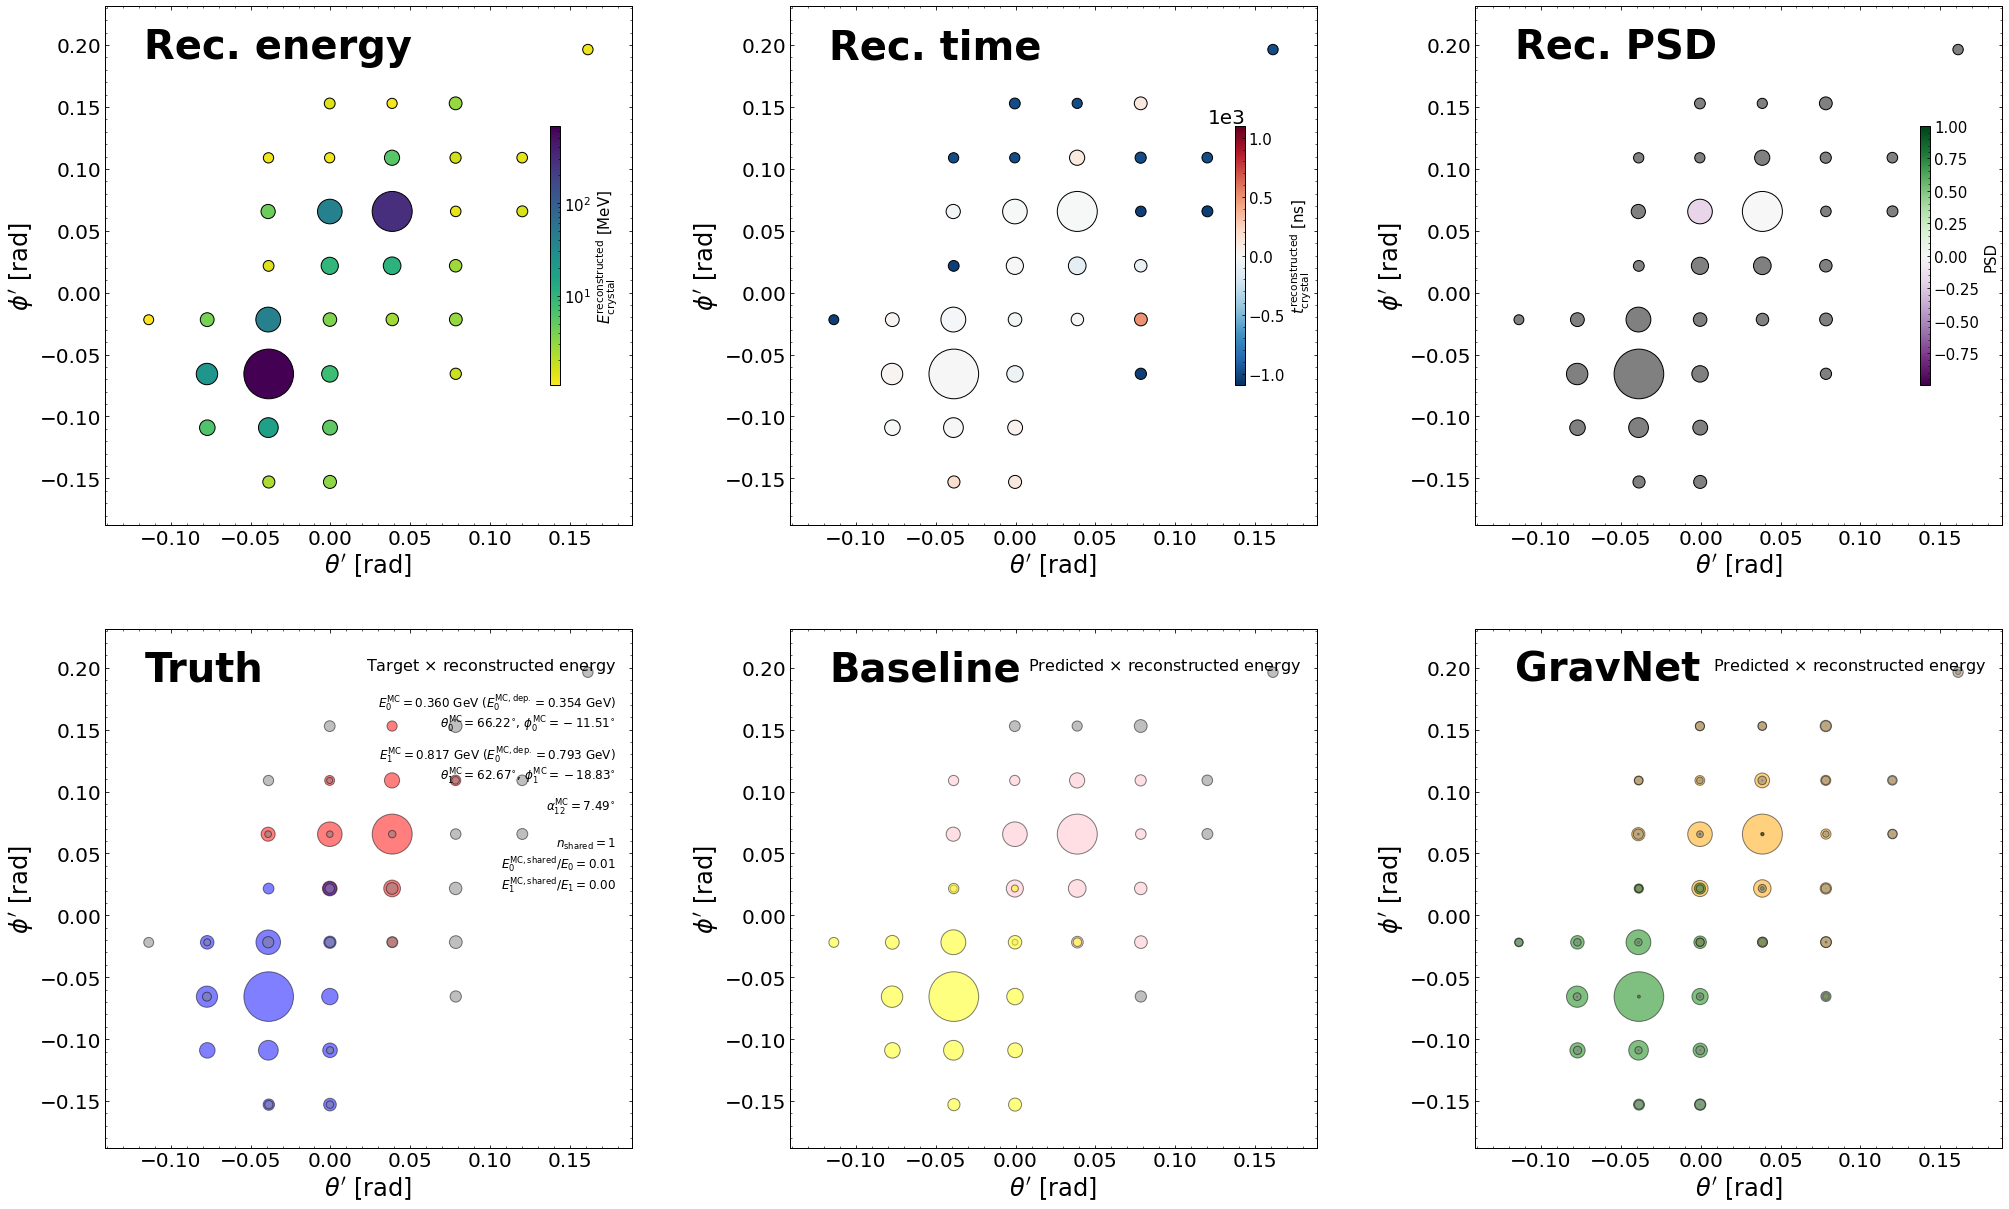

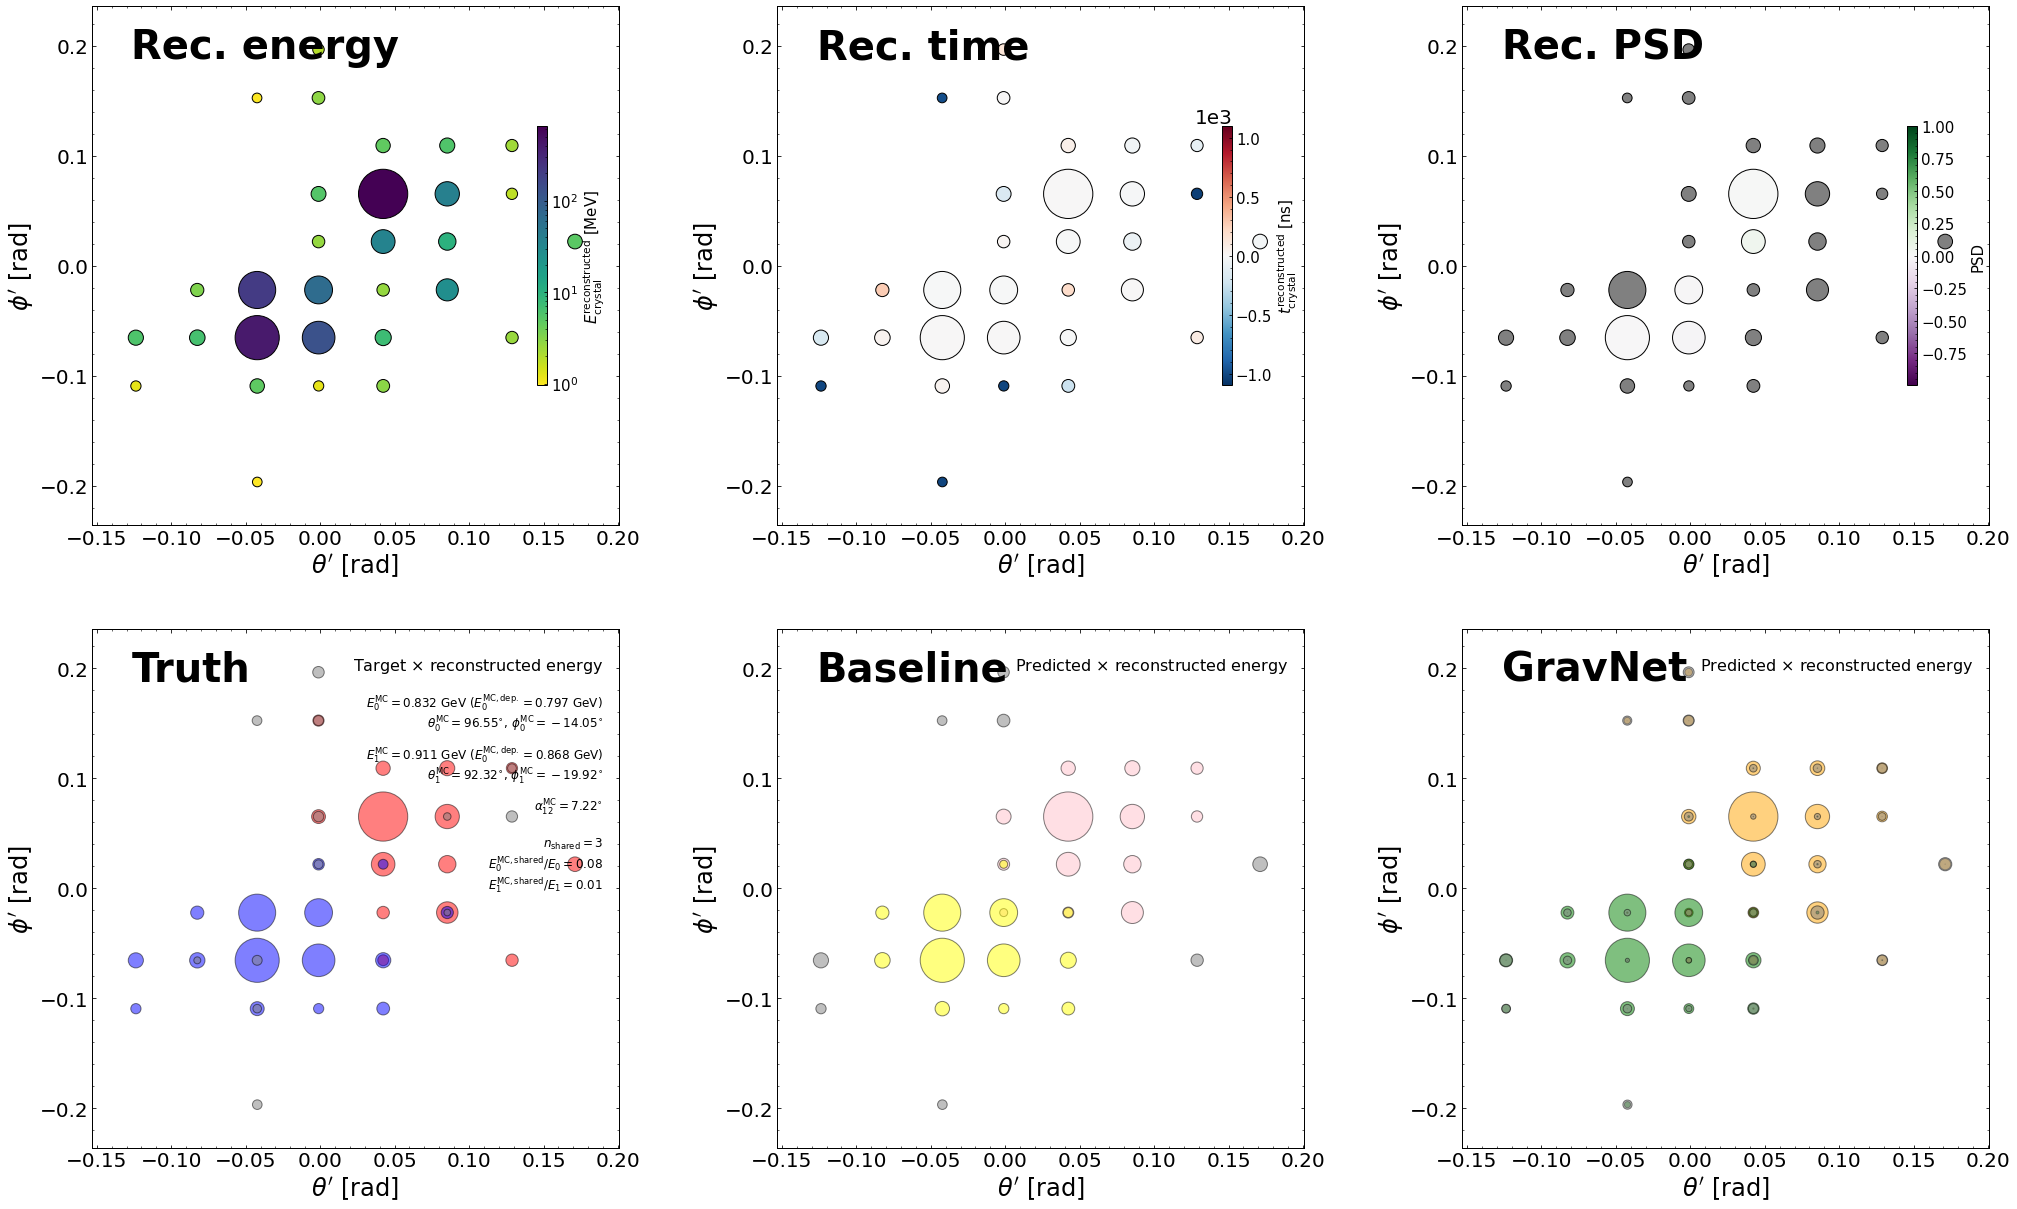

In [5]:
for idx in range(0,10):
    
#     if idx !=1:
#         continue
            
    range_theta = [np.min(input_theta[idx]), np.max(input_theta[idx])]
    range_phi = [np.min(input_phi[idx]), np.max(input_phi[idx])]
    width_theta = range_theta[1]-range_theta[0]
    width_phi = range_phi[1]-range_phi[0]
    range_theta[0] -= width_theta*0.1
    range_theta[1] += width_theta*0.1
    range_phi[0] -= width_phi*0.1
    range_phi[1] += width_phi*0.1

    # display of multiple plots (make it large!)
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    import matplotlib.patches as patches

    fig = plt.figure(figsize=(34,21))
    gs = fig.add_gridspec(2, 3)
    plt.subplots_adjust(wspace=0.3)
    markerscale = 30

    # ----
    # ECLCALDIGIT ENERGIES (INPUT)
    ax00 = fig.add_subplot(gs[0, 0])
    ax00.set_xlabel(r'$\theta^{\prime}$ [rad]')
    ax00.set_ylabel(r'$\phi^{\prime}$ [rad]')

    im = plt.scatter( input_theta[idx], 
                input_phi[idx],
                c = input_energy[idx]*1000,
                s = np.sqrt(input_energy[idx]*10000)*markerscale,
                cmap = 'viridis_r', 
                alpha = 1.0,
                norm=mpl.colors.LogNorm(),
                edgecolor='black')
    _=plt.text(0.075, 0.90, r'Rec. energy', fontsize=40, fontweight='bold', transform=ax00.transAxes, horizontalalignment='left')
    ax00.set_xlim(range_theta)
    ax00.set_ylim(range_phi)

    cbaxes = inset_axes(ax00, width="100%", height="100%", loc='lower left',
                       bbox_to_anchor=(0.825,0.25,.02,.5), bbox_transform=ax00.transAxes) 
    cbar = plt.colorbar(cax=cbaxes, orientation='vertical')
    cbar.ax.tick_params(labelsize=15) 
    cbar.set_label(r'$E_{\rm{crystal}}^{\rm{reconstructed}}$ [MeV]', size=15)

    # ----
    # ECLCALDIGIT Time (INPUT)
    ax01 = fig.add_subplot(gs[0, 1])
    ax01.set_xlabel(r'$\theta^{\prime}$ [rad]')
    ax01.set_ylabel(r'$\phi^{\prime}$ [rad]')

    cmap=copy.copy(plt.cm.get_cmap('RdBu_r'))
    cmap.set_under('Gray')

    im = plt.scatter( input_theta[idx], 
            input_phi[idx],
            c = time[idx],
            s = np.sqrt(input_energy[idx]*10000)*markerscale,
            cmap = cmap, 
            alpha = 1.0,
            edgecolor='black')

    _=plt.text(0.075, 0.90, r'Rec. time', fontsize=40, fontweight='bold', transform=ax01.transAxes, horizontalalignment='left')
    ax01.set_xlim(range_theta)
    ax01.set_ylim(range_phi)
    
    plt.clim(-1.1e3, 1.1e3)  # identical to caxis([-4,4]) in MATLAB
    cbformat = mpl.ticker.ScalarFormatter()   # create the formatter
    cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.

    cbaxes = inset_axes(ax01, width="100%", height="100%", loc='lower left',
                       bbox_to_anchor=(0.825,0.25,.02,.5), bbox_transform=ax01.transAxes) 
    cbar = plt.colorbar(cax=cbaxes, orientation='vertical', format=cbformat)
    cbar.ax.tick_params(labelsize=15) 
    cbar.set_label(r'$t_{\rm{crystal}}^{\rm{reconstructed}}$ [ns]', size=15)

   
    # ----
    # ECLCALDIGIT Hadron Energy (INPUT)
    ax02 = fig.add_subplot(gs[0, 2])
    ax02.set_xlabel(r'$\theta^{\prime}$ [rad]')
    ax02.set_ylabel(r'$\phi^{\prime}$ [rad]')

    cmap=copy.copy(plt.cm.get_cmap('PRGn'))
    cmap.set_under('Gray')
    
    # mask bad fittypes
    psd_masked = [x if ft>=0 else -1 for x, ft in zip(psd[idx], fittype[idx])]
    
    im = plt.scatter( input_theta[idx], 
            input_phi[idx],
            c = psd_masked,
            s = np.sqrt(input_energy[idx]*10000)*markerscale,
            cmap = cmap, 
            alpha = 1.0,
            edgecolor='black')

    _=plt.text(0.075, 0.90, r'Rec. PSD', fontsize=40, fontweight='bold', transform=ax02.transAxes, horizontalalignment='left')
    ax02.set_xlim(range_theta)
    ax02.set_ylim(range_phi)
    plt.clim(-0.999, 1.0) 

    cbaxes = inset_axes(ax01, width="100%", height="100%", loc='lower left',
                       bbox_to_anchor=(0.825,0.25,.02,.5), bbox_transform=ax02.transAxes) 
    cbar = plt.colorbar(cax=cbaxes, orientation='vertical')
    cbar.ax.tick_params(labelsize=15) 
    cbar.set_label(r'PSD', size=15)
   
    # ----
    # TRUTH (=TARGET WEIGHTS)
    ax01 = fig.add_subplot(gs[1, 0])
    ax01.set_xlabel(r'$\theta^{\prime}$ [rad]')
    ax01.set_ylabel(r'$\phi^{\prime}$ [rad]')

    im = plt.scatter( input_theta[idx], 
                input_phi[idx],
                c = 'r',
                s = np.sqrt(target_t0[idx]*input_energy[idx]*10000)*markerscale,
                alpha =0.5,
                norm=mpl.colors.LogNorm(),
                edgecolor='black')

    im = plt.scatter( input_theta[idx], 
                input_phi[idx],
                c = 'b',
                s = np.sqrt(target_t1[idx]*input_energy[idx]*10000)*markerscale,
                alpha =0.5,
                norm=mpl.colors.LogNorm(),
                edgecolor='black')

    im = plt.scatter( input_theta[idx], 
                input_phi[idx],
                c = 'gray',
                s = np.sqrt(target_tbkg[idx]*input_energy[idx]*10000)*markerscale,
                alpha =0.5,
                norm=mpl.colors.LogNorm(),
                edgecolor='black')

    _=plt.text(0.97, 0.92, r'Target $\times$ reconstructed energy', fontsize=16, transform=ax01.transAxes, horizontalalignment='right')
    _=ax01.set_xlim(range_theta)
    _=ax01.set_ylim(range_phi)
    
    fs = 12
    _=plt.text(0.075, 0.90, r'Truth', fontsize=40, fontweight='bold', transform=ax01.transAxes, horizontalalignment='left')
    _=plt.text(0.97, 0.85, r'$E_0^{{\rm{{MC}}}}={:.3f}$ GeV ($E_0^{{\rm{{MC, dep.}}}}={:.3f}$ GeV)'.format(mon_E0[idx][0], mon_e0_sel[idx][0]), fontsize=fs, transform=ax01.transAxes, horizontalalignment='right')
    _=plt.text(0.97, 0.81, r'$\theta_0^{{\rm{{MC}}}}={:.2f} ^{{\circ}}$, $\phi_0^{{\rm{{MC}}}}={:.2f} ^{{\circ}}$'.format(np.degrees(mon_theta0[idx][0]), np.degrees(mon_phi0[idx][0])), fontsize=fs, transform=ax01.transAxes, horizontalalignment='right')

    _=plt.text(0.97, 0.75, r'$E_1^{{\rm{{MC}}}}={:.3f}$ GeV ($E_0^{{\rm{{MC, dep.}}}}={:.3f}$ GeV)'.format(mon_E1[idx][0], mon_e1_sel[idx][0]), fontsize=fs, transform=ax01.transAxes, horizontalalignment='right')
    _=plt.text(0.97, 0.71, r'$\theta_1^{{\rm{{MC}}}}={:.2f} ^{{\circ}}$, $\phi_1^{{\rm{{MC}}}}={:.2f} ^{{\circ}}$'.format(np.degrees(mon_theta1[idx][0]), np.degrees(mon_phi1[idx][0])), fontsize=fs, transform=ax01.transAxes, horizontalalignment='right')

    _=plt.text(0.97, 0.65, r'$\alpha_{{12}}^{{\rm{{MC}}}}={:.2f} ^{{\circ}}$'.format(np.degrees(mon_angle[idx][0])), fontsize=fs, transform=ax01.transAxes, horizontalalignment='right')

    _=plt.text(0.97, 0.58, r'$n_{{\rm{{shared}}}}={}$'.format(int(mon_nshared[idx][0])), fontsize=fs, transform=ax01.transAxes, horizontalalignment='right')
    _=plt.text(0.97, 0.54, r'$E_0^{{\rm{{MC, shared}}}}/E_0={:.2f}$'.format(mon_e0_overlap[idx][0]/mon_e0_sel[idx][0]), fontsize=fs, transform=ax01.transAxes, horizontalalignment='right')
    _=plt.text(0.97, 0.50, r'$E_1^{{\rm{{MC, shared}}}}/E_1={:.2f}$'.format(mon_e1_overlap[idx][0]/mon_e1_sel[idx][0]), fontsize=fs, transform=ax01.transAxes, horizontalalignment='right')

    # ----
    # PREDICTED WEIGHTS: BASELINE
    ax11 = fig.add_subplot(gs[1, 1])
    ax11.set_xlabel(r'$\theta^{\prime}$ [rad]')
    ax11.set_ylabel(r'$\phi^{\prime}$ [rad]')

    import heapq
    n2 = heapq.nlargest(2, set(np.concatenate([clstid0[idx], clstid1[idx]])))
    
    cluster_0a = [ cw if cw > 0 and cid==n2[0] else 0. for cid, cw in zip(clstid0[idx], clstw0[idx])]
    cluster_0b = [ cw if cw > 0 and cid==n2[0] else 0. for cid, cw in zip(clstid1[idx], clstw1[idx])]
    cluster_0 = [a + b for a, b in zip(cluster_0a, cluster_0b)]
    cluster_1a = [ cw if cw > 0 and cid==n2[1] else 0. for cid, cw in zip(clstid0[idx], clstw0[idx])]
    cluster_1b = [ cw if cw > 0 and cid==n2[1] else 0. for cid, cw in zip(clstid1[idx], clstw1[idx])]
    cluster_1 = [a + b for a, b in zip(cluster_1a, cluster_1b)]
    
    #THERE IS NO FRACTIONAL BKG WEIGHT IN DEFAULT CLUSTERING - IT EITHER IS IN CLUSTER(S) OR NOT
    cluster_bkg = [ 1 if cid==-1. else 0. for cid, cw in zip(clstid0[idx], clstw0[idx])]

    im = plt.scatter( input_theta[idx], 
            input_phi[idx],
            c = 'pink',
            s = np.sqrt(cluster_0*input_energy[idx]*10000)*markerscale,
            alpha =0.5,
            norm=mpl.colors.LogNorm(),
            edgecolor='black')

    im = plt.scatter( input_theta[idx], 
            input_phi[idx],
            c = 'yellow',
            s = np.sqrt(cluster_1*input_energy[idx]*10000)*markerscale,
            alpha =0.5,
            norm=mpl.colors.LogNorm(),
            edgecolor='black')

    im = plt.scatter( input_theta[idx], 
            input_phi[idx],
            c = 'gray',
            s = np.sqrt(cluster_bkg*input_energy[idx]*10000)*markerscale,
            alpha =0.5,
            norm=mpl.colors.LogNorm(),
            edgecolor='black')

    _=ax11.set_xlim(range_theta)
    _=ax11.set_ylim(range_phi)
    _=plt.text(0.97, 0.92, r'Predicted $\times$ reconstructed energy', fontsize=16, transform=ax11.transAxes, horizontalalignment='right')
    _=plt.text(0.075, 0.90, r'Baseline', fontsize=40, fontweight='bold', transform=ax11.transAxes, horizontalalignment='left')

    # ----
    # PREDICTED WEIGHTS: GRAVNET
    ax02 = fig.add_subplot(gs[1, 2])
    ax02.set_xlabel(r'$\theta^{\prime}$ [rad]')
    ax02.set_ylabel(r'$\phi^{\prime}$ [rad]')

    im = plt.scatter( input_theta[idx], 
                input_phi[idx],
                c = 'orange',
                s = np.sqrt(target_p0[idx]*input_energy[idx]*10000)*markerscale,
                alpha =0.5,
                norm=mpl.colors.LogNorm(),
                edgecolor='black')


    im = plt.scatter( input_theta[idx], 
                input_phi[idx],
                c = 'g',
                s = np.sqrt(target_p1[idx]*input_energy[idx]*10000)*markerscale,
                alpha =0.5,
                norm=mpl.colors.LogNorm(),
                edgecolor='black')

    im = plt.scatter( input_theta[idx], 
                input_phi[idx],
                c = 'gray',
                s = np.sqrt(target_pbkg[idx]*input_energy[idx]*10000)*markerscale,
                alpha =0.5,
                norm=mpl.colors.LogNorm(),
                edgecolor='black')

    _=ax02.set_xlim(range_theta)
    _=ax02.set_ylim(range_phi)
    _=plt.text(0.97, 0.92, r'Predicted $\times$ reconstructed energy', fontsize=16, transform=ax02.transAxes, horizontalalignment='right')
    _=plt.text(0.075, 0.90, r'GravNet', fontsize=40, fontweight='bold', transform=ax02.transAxes, horizontalalignment='left')
    

    plt.savefig(f'plot_prepare_{idx}.pdf', bbox_inches='tight')
#     plt.close()

In [ ]:
psd[9]

In [ ]:
fittype[9]

In [ ]:
m = x[:, -1] != 0
m.shape

In [ ]:
y = x[m]